# Imports

In [1]:
import numpy as np
import cupy as cp
import pyquasar as pq

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format='retina'

In [2]:
air = {"density": 1.21, "speed": 343, "impedance": 415}

In [3]:
f = 10

In [4]:
def u(t, p, n):
    return np.zeros_like(p[..., 0])


def source(t, p, n):
    # return j * air["density"] * 2 * np.pi
    # s = sin(2pi f t)
    # v = ds/dt = 2pi f cos(2pi f t)
    # vn = n v
    omega = 2 * np.pi * f
    return air["density"] * np.sin(omega * t) / (0.0025)
    return 0


def flow(p, n):
    return np.zeros_like(p[..., 0])


def ub(p, n):
    return 2 * (n[..., 0] - n[..., 1]) + p[..., 0] - p[..., 1]

In [5]:
device = "cuda"

In [6]:
mesh = pq.Mesh.load("cube.geo", refine_k=1)
domains = [pq.FemDomain(domain, device=device) for domain in mesh]

In [397]:
time_mesh = pq.TimeMesh(1 / (air["speed"] ** 2), 0.0, 0.5, 51, 1.0)

In [398]:
problem = pq.HyperbolicProblem(domains, time_mesh, device=device)

In [399]:
materials = {"air": {"source": {"source": source}, "gamma": 1}}
# materials = {"air": {"gamma": 1}}
problem.assembly()

In [400]:
problem.add_init_conds(["dirichlet"], constant_time_step=True)

In [401]:
pts = np.linspace(1, 2.75, 201)
pts = pts + 1.025
pts = np.concatenate(
    [pts[:, None], np.ones_like(pts)[:, None], 1.025 * np.ones_like(pts)[:, None]],
    axis=1,
)

In [402]:
proj = problem.tabulate(cp.asarray(pts))

100%|██████████| 1/1 [00:00<00:00, 213.15it/s]


In [403]:
sols = problem.solve(
  u,
  ["dirichlet"],
  materials,
  rtol=1e-8,
  verbose=False,
  proj=proj,
  consant_step_time=True,
)

min:  0e+00 | max:  0e+00 | mean:  0e+00: 100%|██████████| 49/49 [00:00<00:00, 225.53it/s]


In [404]:
len(sols)

51

In [405]:
pts = np.array(
  [
    [1.025, 1, 1.025],
    [1.025, 2, 1.025],
    [1.025, 3, 1.025],
    [1.025, 4, 1.025],
    [1.025, 5, 1.025],
  ]
)

In [406]:
proj = problem.tabulate(cp.asarray(pts))
ps = proj @ np.array(sols).T

100%|██████████| 1/1 [00:00<00:00, 278.90it/s]


In [407]:
ps[ps != 0] = 20 * np.log10(np.abs(ps[ps != 0]) / 0.00002)

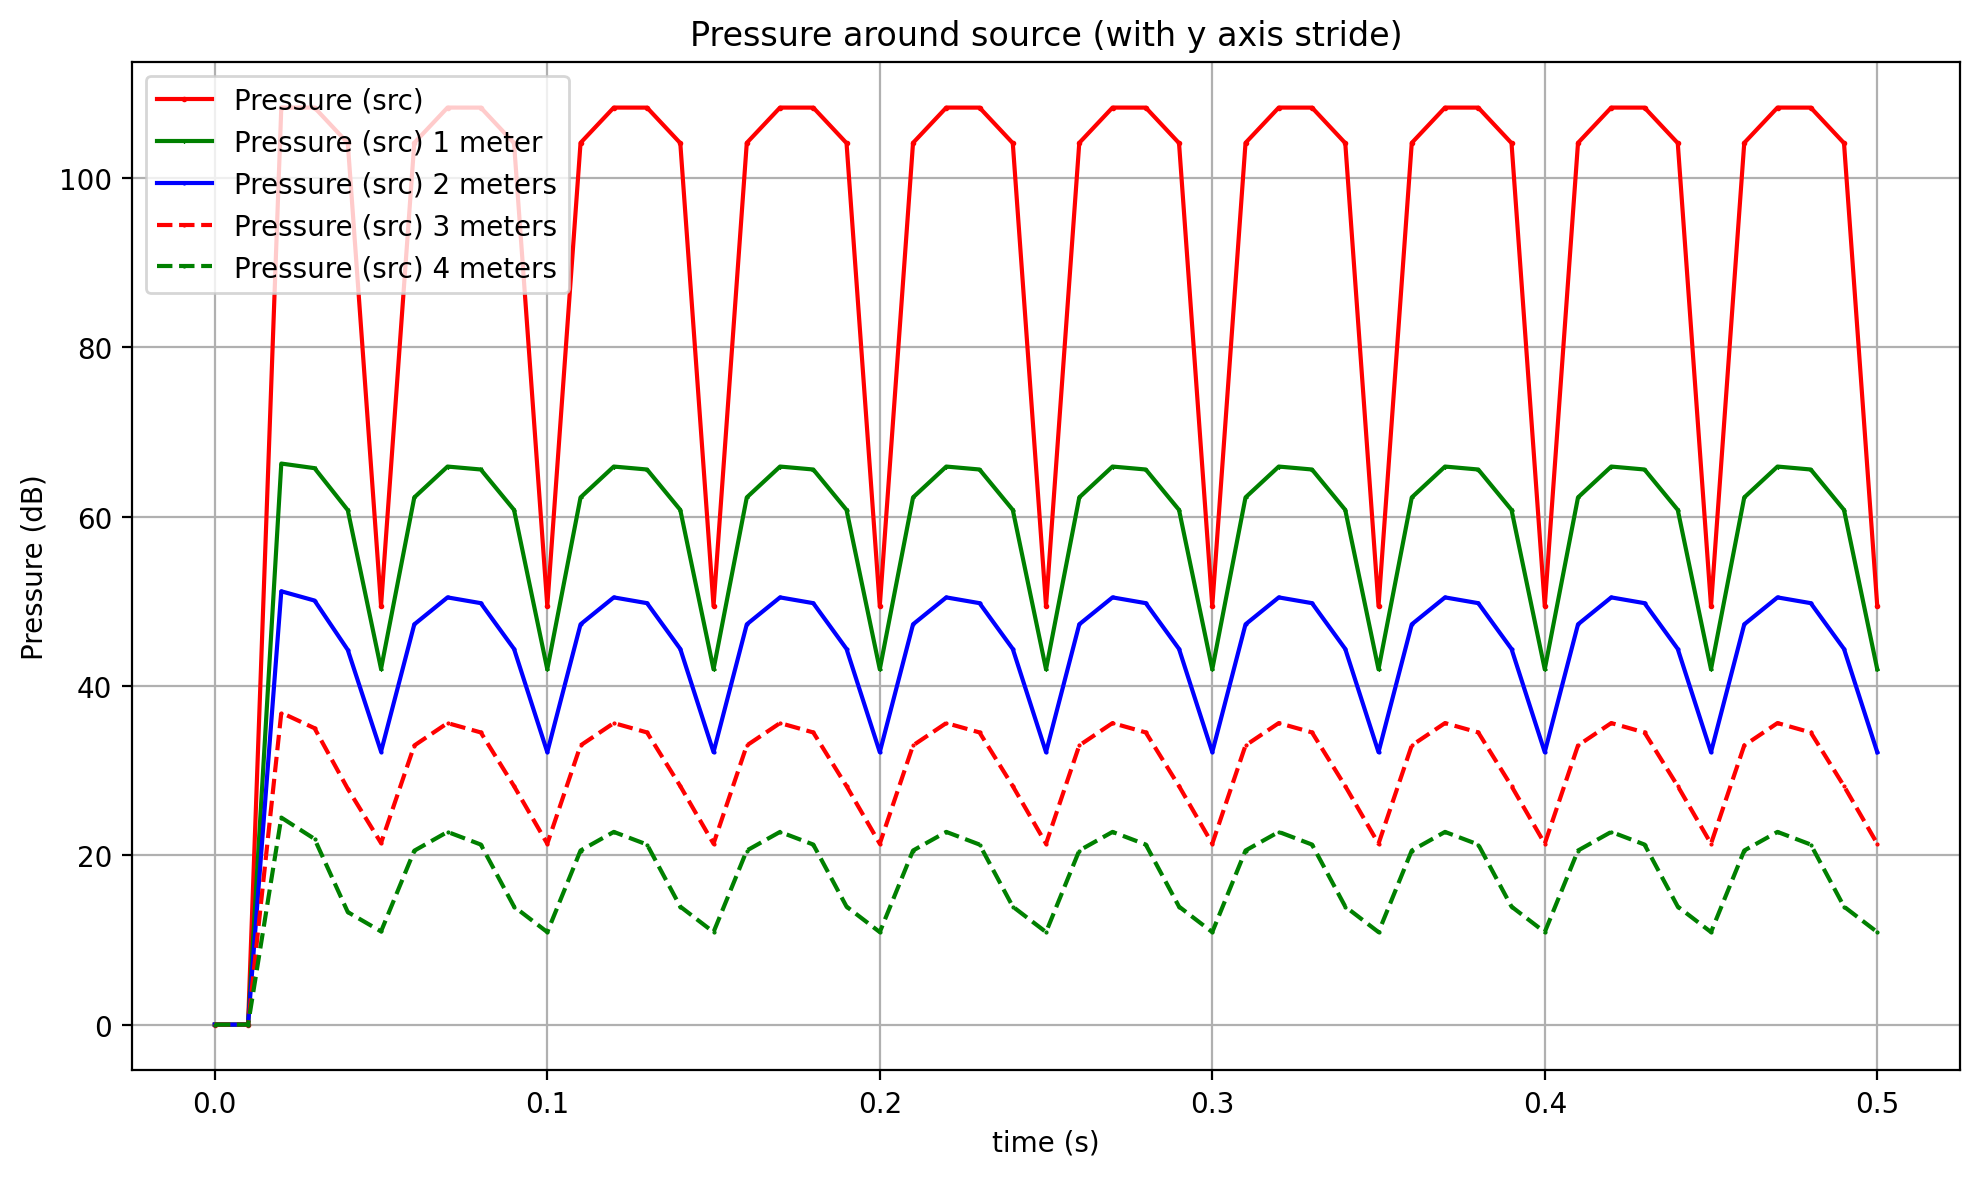

In [408]:
plt.figure(figsize=(10, 6))
plt.plot(time_mesh.mesh, ps[0], label="Pressure (src)", color="red", linestyle="-", marker="o", ms=1)
plt.plot(time_mesh.mesh, ps[1], label="Pressure (src) 1 meter", color="green", linestyle="-", marker="*", ms=1)
plt.plot(time_mesh.mesh, ps[2], label="Pressure (src) 2 meters", color="blue", linestyle="-", marker=".", ms=1)
plt.plot(time_mesh.mesh, ps[3], label="Pressure (src) 3 meters", color="red", linestyle="--", marker=".", ms=1)
plt.plot(time_mesh.mesh, ps[4], label="Pressure (src) 4 meters", color="green", linestyle="--", marker=".", ms=1)


# Add labels and title
plt.xlabel("time (s)")
plt.ylabel("Pressure (dB)")
plt.title("Pressure around source (with y axis stride)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()